In [1]:
import cv2 # biblioteca de processamento de imagens
import numpy as np # funções numéricas
import matplotlib.pyplot as plt # visualização
from PIL import Image 
import requests
import random

def url_to_image(url):
  """
  Faz o download da imagem, converte em np.array e abre usando o OpenCV
  """
  resp = requests.get(url, stream=True)
  image = Image.open(resp.raw)

  return image

def sp_noise(image,prob):
  '''
  Adicionar o ruído sal e pimenta
  prob: probabilidade do ruído
  '''
  # inicializa a imagem de saída
  output = np.zeros(image.shape,np.uint8)
  thres = 1 - prob 

  #gera um ruído na imagem de 0 ou 255 dependendo da probabilidade
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          rdn = random.random()
          if rdn < prob:
              output[i][j] = 0
          elif rdn > thres:
              output[i][j] = 255
          else:
              output[i][j] = image[i][j]
  return output

def add_noise(original_image, noise_mean = 0, noise_variance = 64):
  # cria a matriz de ruído
  noise = np.random.normal(noise_mean, noise_variance, (original_image.shape))
  # adiciona o ruído à imagem original
  noisy_image = cv2.add(np.float64(original_image),noise)

  return noisy_image, noise

In [2]:
img = url_to_image("https://oryon.co.uk/app/uploads/2019/08/Brain-MRI-e1565353833878.jpg")

# img = url_to_image("https://cdn.wallpapersafari.com/15/86/jSmabs.jpg")

# img = url_to_image("https://animals.sandiegozoo.org/sites/default/files/2016-11/animals_hero_giraffe_1_0.jpg")

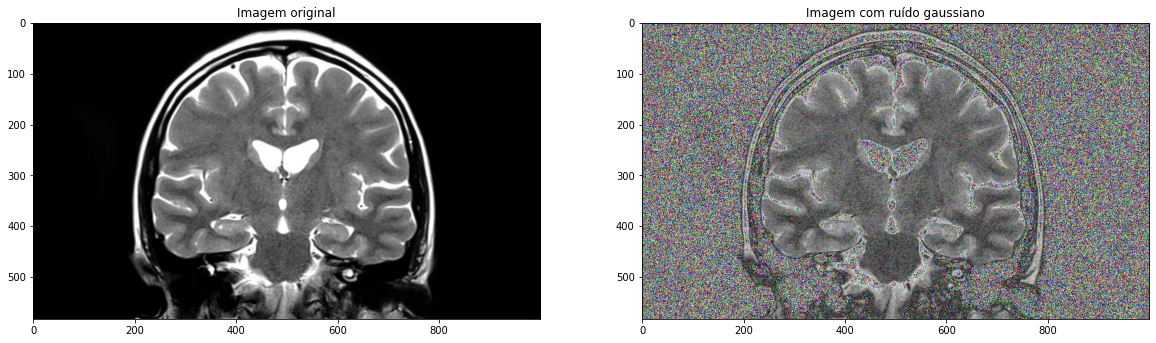

In [3]:
img = np.array(img)
sp_img = sp_noise(img, prob = 0.1)
gaussian_img,_ = add_noise(img,noise_variance = 32)
gaussian_img = np.uint8(gaussian_img)

# img = cv2.blur(img, (3,3))

plt.figure(figsize = (20,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Imagem original")
plt.subplot(1,2,2)
plt.title("Imagem com ruído gaussiano")
plt.imshow(gaussian_img);

In [4]:
img.shape

(583, 1000, 3)

## SLIC

In [5]:
lab_img = cv2.cvtColor(gaussian_img, cv2.COLOR_RGB2LAB)
L = np.full(shape = (lab_img.shape[0], lab_img.shape[1]), fill_value = -1)

In [6]:

# from time import time
# start_t = time()
# for i in range(lab_img.shape[0]):
#   for j in range(lab_img.shape[1]):
#     img_5d[i,j] = np.append(lab_img[i,j], [i,j])
    
# end_t = time()
# print("Total de tempo do loop: {}".format(end_t - start_t))
# img_label

In [7]:
k = 1000
m = 10
N = lab_img.shape[0]*lab_img.shape[1]
h = int(np.sqrt(N/k))

In [8]:
centers_x = list(range(int(h), lab_img.shape[0], int(h)))
centers_y = list(range(int(h), lab_img.shape[1], int(h)))

In [9]:
class Cluster():
  def __init__(self, center, index):
    self.center = center
    self.index = index
    self.pixels = set()
    self.cov_matrix = np.array([])
    

clusters = []
idx = 0
for x in centers_x:
  for y in centers_y:
    cluster = Cluster(center = (x,y), index = idx)
    clusters.append(cluster)
    idx+=20

In [10]:
def compute_gradient(img,x,y):
  gx = img[x + 1][y][0] - img[x-1][y][0] 
  gy = img[x][y+1][0] - img[x][y-1][0]
  
  module = np.sqrt(gx**2 + gy**2)
  # print(gx, gy)
  return module

def first_update_cluster_center(clusters = []):
  for cluster in clusters:
    cluster_center = cluster.center
    x = cluster_center[0]
    y = cluster_center[1]
    
    current_gradient = compute_gradient(img, x, y)

    # print("centro antes: ", cluster.center)
    # pixels ao redor do centro
    for (dx, dy) in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
      
      #new x, new y são as posições dos pixels ao redor do centro
      nx = x + dx
      ny = y + dy

      # calcula o gradiente em cada um desses novos pontos
      gradient = compute_gradient(img, nx,ny)

      if gradient < current_gradient:
        cluster.center = (nx, ny)
        cluster.color_vec = img[nx,ny]
      # print("centro depois: ", cluster.center)

first_update_cluster_center(clusters)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in ubyte_scalars
  


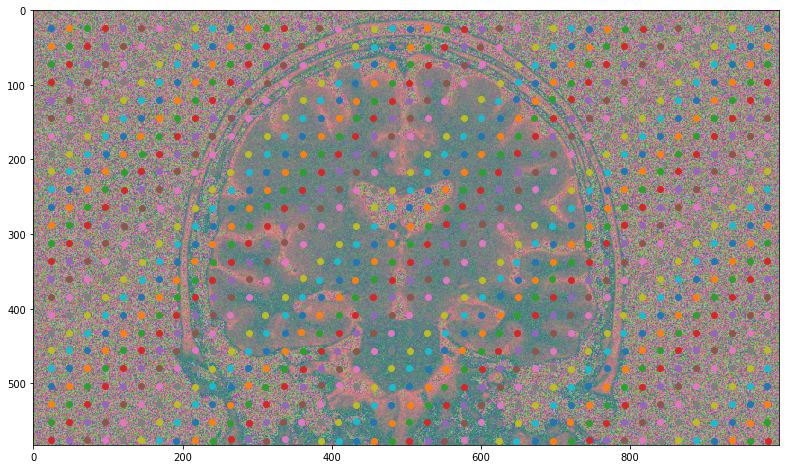

In [11]:
# visualização dos clusters iniciais
plt.figure(figsize = (15,8))
plt.imshow(lab_img)
for cluster in clusters:
  plt.scatter(cluster.center[1], cluster.center[0])

In [12]:
from tqdm import tqdm

def compute_covmatrix(pixels):
  mean_x, mean_y = 0, 0

  # componentes da matriz de covariância
  C00, C01, C10, C11 = 0,0,0,0

  for px, py in pixels:
    mean_x += px
    mean_y += py

  mean_x = mean_x/len(pixels)
  mean_y = mean_y/len(pixels)


  for x,y in pixels:
    C00 += (x-mean_x)**2
    C01 += (x-mean_x)*(y-mean_y)
    C10 += (x-mean_x)*(y-mean_y)
    C11 += (y-mean_y)**2

  cov_matrix = np.array([[C00,C10],
                        [C01, C11]])/len(pixels)

  return cov_matrix

def compute_d_squared(img, h, pixel = (), center = (), m = 10):

  xp = np.array(pixel)
  cp = np.array(center)

  # cor lab de um pixel da janela 
  color_px = np.int8(img[xp[0], xp[1]])

  # cor lab do pixel central
  color_ct = np.int8(img[cp[0], cp[1]])

  ds = np.linalg.norm(xp- cp, ord = 2)
  dc = np.linalg.norm( color_px - color_ct, ord = 2)

  # precisa passar os argumentos do segundo termo para np.int8 para que a subtração seja feita corretamente
  # do contrário, [1,1,0] - [3,3,3] = [254, 254, 253], o que causa problemas na hora de calcular a distância
  return np.sqrt(((m/h)*ds)**2  + dc**2)

def update_center(cluster_pixels):

  px_x = []
  px_y = []

  for px in cluster_pixels:
    px_x.append(px[0])
    px_y.append(px[1])

  center_x = np.mean(np.array(px_x))
  center_y = np.mean(np.array(px_y))

  return (int(center_x), int(center_y))

store_new_D = list()
store_D = list()
store_d = list()
D = np.full(shape = (lab_img.shape[0], lab_img.shape[1]), fill_value = 10000)

# matriz cujos elementos são as posições daquela entrada
# pode ser inicializada uma única vez fora de loops para otimização
position_matrix = np.zeros((lab_img.shape[0],lab_img.shape[1], 2))
for i in range(position_matrix.shape[0]):
  for j in range(position_matrix.shape[1]):
    position_matrix[i,j] = [i,j]

# dicionario que vai guardar todos os labels de todos os pixels
# da seguinte forma: labels_dict[(pixel_x, pixel_y)] = label
labels_dict = dict()
for i in range(lab_img.shape[0]):
  for j in range(lab_img.shape[1]):
    labels_dict[(i,j)] = -1


counter = 0
number_of_iterations = 3
while counter < number_of_iterations:
  # em cada cluster
  for cluster in tqdm(clusters):
    # acha o centro
    xc, yc = cluster.center
    
    ## olha numa janela 2h x 2h e faz o cálculo de d para comparar com D

    # janela na imagem LAB e no D max e min são usados para lidar com as bordas da imagem, i.e. não ir para valores menores que 0 e além da imagem
    window_img = lab_img[max(0,xc-h):min(lab_img.shape[0] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]
    D_window = D[max(0,xc-h):min(lab_img.shape[0] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]
    store_D.append(D_window.copy())
    # posição do pixel menos posição do centro
    subtract = position_matrix[max(0,xc-h):min(lab_img.shape[0] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)] - np.array([xc, yc])

    ds = np.linalg.norm(subtract, axis = 2)**2

    # cor do pixel menos cor do centro
    color_subtract = np.array(window_img, dtype = np.int8) -  np.array(lab_img[xc, yc], dtype = np.int8)

    dc = np.linalg.norm(color_subtract, axis = 2)**2

    # distancia total entre dois píxels considerando a cor no espaço LAB e a distância euclideana
    d = np.sqrt(((m/h)**2)*dc + ds)
    store_d.append(d)
    # comparação entre d e D
    d_condition = d<D_window

    new_D_window = ~d_condition*1*D_window + d_condition*1*d

    if D_window[int(d.shape[0]/2), int(d.shape[0]/2)] == 100000:
      new_D_window[int(d.shape[0]/2), int(d.shape[0]/2)] = 100000

    store_new_D.append(new_D_window)
    # print(new_D_window)
    D[max(0,xc-h):min(lab_img.shape[0] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)] = new_D_window

    L[max(0,xc-h):min(lab_img.shape[0] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)] = d_condition*cluster.index
    
    # valores dos pixels da janela atual
    x_range = list(range(max(0,xc-h),min(lab_img.shape[0] - 1,xc+h+1)))
    y_range = list(range(max(0,yc-h),min(lab_img.shape[1] - 1, yc+h+1)))  

    #determinar a relação entre os índices do L e do d_condition para poder colocar os pixels (encontrados através de L) em cluster.pixels
    d_xs = list(range(0,d_condition.shape[0]))
    d_ys = list(range(0, d_condition.shape[1]))

    # dicionarios com a conversão entre os valores reais da janela (os valores dos pixels na imagem) e o de d (que vão de 0 até tamanho_janela)
    x_conversion_dict = dict(zip(d_xs, x_range))
    y_conversion_dict = dict(zip(d_ys, y_range))

    x_cond, y_cond = np.where(d_condition == 1)

    # pixels com o label atual
    pixels_with_label = list(zip(x_cond, y_cond))

    # definir o valor de cada pixel que pertence ao cluster atual como sendo o label cluster.index
    for px, py in pixels_with_label:
      px_true = x_conversion_dict[px]
      py_true = y_conversion_dict[py]
      labels_dict[(px_true, py_true)] = cluster.index
              
    # designa os pixels de certo cluster à variavel cluster.pixels
    pixels_of_cluster = [k for k,v in labels_dict.items() if v == cluster.index]
    cluster.pixels = pixels_of_cluster
   
    # atualiza o centro do cluster
    cluster.center = update_center(cluster.pixels)
    
    # na última iteração
    if counter == number_of_iterations-1:
      # calcula a matrix de covariância
      cov_matrix = compute_covmatrix(cluster.pixels)
      cluster.cov_matrix = cov_matrix
      

  #   # calcula a diferença entre a posição dos dois centros (anterior e atual)
  #   error_vec = np.array([center[0],center[1]]) - np.array([cluster.center[0], cluster.center[1]])
  #   error_magnitude += np.sqrt(error_vec.dot(error_vec))

  #   print(np.sqrt(error_vec.dot(error_vec)))
  #   # print(error_magnitude, cluster.center)
  # mean_error = error_magnitude/len(clusters)
  # print(mean_error)
  counter+=1

100%|██████████| 984/984 [01:02<00:00, 15.63it/s]


In [13]:
dc.shape

(39, 39)

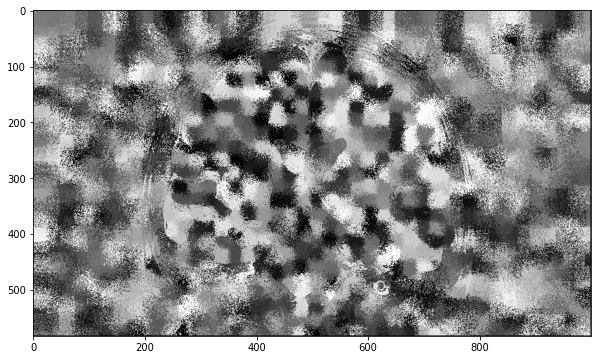

In [14]:
# visualização dos clusters sem forçar conectividade (SLIC normal)
import matplotlib
import random
gray_pixels = np.full(shape = (lab_img.shape[0], lab_img.shape[1]), fill_value = 0, dtype = np.float32)

possible_gray_levels = list(np.arange(0,1,1/k))
plt.figure(figsize = (10,15))
for cluster in clusters:
  color = random.choice(possible_gray_levels)
  for px,py in cluster.pixels:
    # print(color, px, py)
    gray_pixels[px,py] = color

plt.imshow(gray_pixels, cmap = "gray")

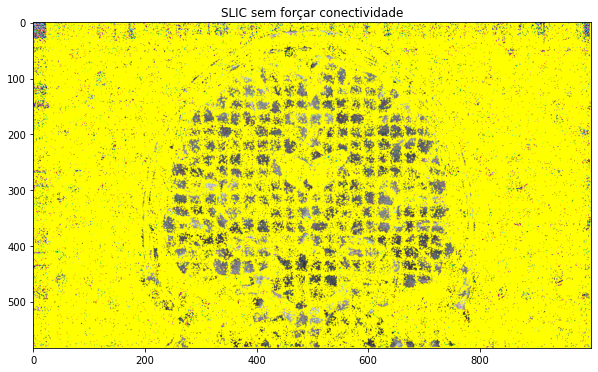

In [15]:
from skimage.segmentation import mark_boundaries
plt.figure(figsize = (10,8))
plt.imshow(mark_boundaries(gaussian_img, np.int8(gray_pixels*255), color = [1,1,0]))
plt.title("SLIC sem forçar conectividade", fontdict = {'fontsize': 12}, );

100%|██████████| 582/582 [00:22<00:00, 25.72it/s]


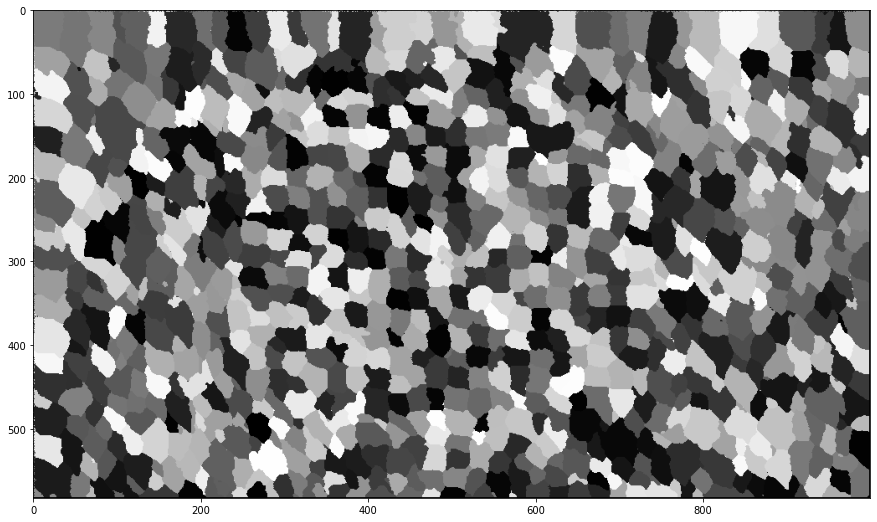

In [16]:
# forçar conectividade dentro dos clusters (SLIC normal)
L_copy = gray_pixels.copy()
# pra cada pixel
for i in tqdm(range(L_copy.shape[0]-1)):
  for j in range(L_copy.shape[1]-1):
    # olhar uma janela de certo tamanho ao redor dele
    window = L_copy[i-2:i+3, j-2:j+3]
    # se um pixel na janela for diferente do pixel central da janela
    # o elemento equivalente de diff_window = 1, senão é 0
    diff_window = 1*window != L_copy[i,j]
    # se a maioria for diferente
    if np.sum(diff_window)>12:
      # print("mudar pixel")
      # procura qual o label que possui a maior contagem
      # e dá esse label para aquele pixel
      pixels, count = np.unique(window, return_counts=True)
      index_count = np.where(count == np.max(count))[0][0]
      L_copy[i,j] = pixels[index_count]
    else:
      continue
      # print("Não mudar pixel")

np.unique(L_copy, return_counts=True)
plt.figure(figsize = (15,10))
plt.imshow(L_copy, cmap = "gray")

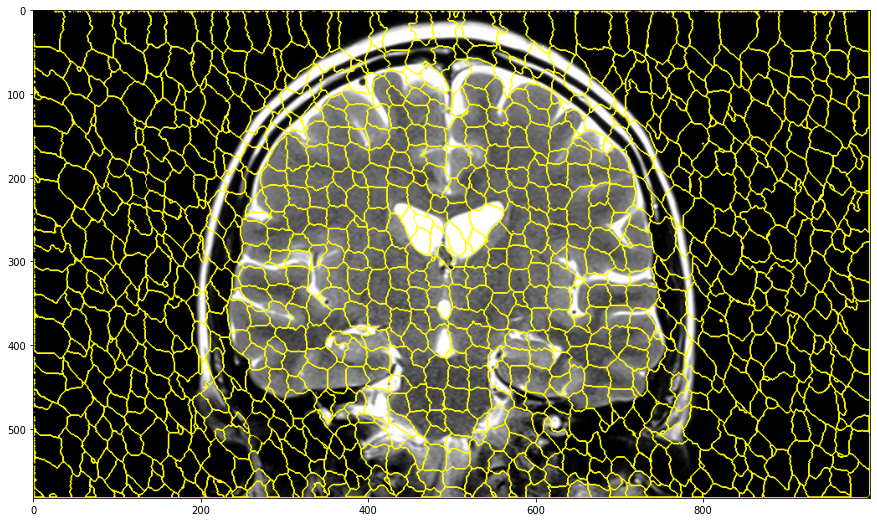

In [17]:
from skimage.segmentation import mark_boundaries
plt.figure(figsize = (15,10))
plt.imshow(mark_boundaries(img, np.int8(L_copy*255)))

## Implementando o PowerSLIC

In [18]:
def compute_modified_d(cov_matrix, pixel, center):
  px_vec = np.array([pixel[0], pixel[1]])
  center_vec = np.array([center[0], center[1]])

  subtraction = np.int8(px_vec) - np.int8(center_vec)

  inv_cov_matrix = np.linalg.inv(cov_matrix)

  return np.sqrt(np.matmul(subtraction,np.matmul(inv_cov_matrix, subtraction.reshape(-1,1))))**2

new_L = np.full(L.shape, -1)
# D = np.full(shape = L.shape, fill_value = np.infty)

for cluster in tqdm(clusters):
  # acha o centro
  center = cluster.center
  cov_matrix = cluster.cov_matrix

  for i in range(int(center[0] - h), int(center[0] + h), 1):  
    if i >= 0 and i < lab_img.shape[0]:
      for j in range(int(center[1] - h), int(center[1] + h), 1):
        if j >= 0 and j < lab_img.shape[1]:
          d = compute_modified_d(cov_matrix, pixel = (i,j), center = center)

          # se a distância for menor que a distância definida anteriormente
          # atualiza D, muda o label de L[i,j] e atualiza os pixels do cluster
          if d < D[i,j]:
            D[i,j] = d
            new_L[i,j] = cluster.index
            labels_dict[(i,j)] = cluster.index
  
  pixels_of_cluster = [k for k,v in labels_dict.items() if v == cluster.index]
  cluster.pixels = pixels_of_cluster

100%|██████████| 984/984 [03:55<00:00,  4.18it/s]


<Figure size 720x1080 with 0 Axes>

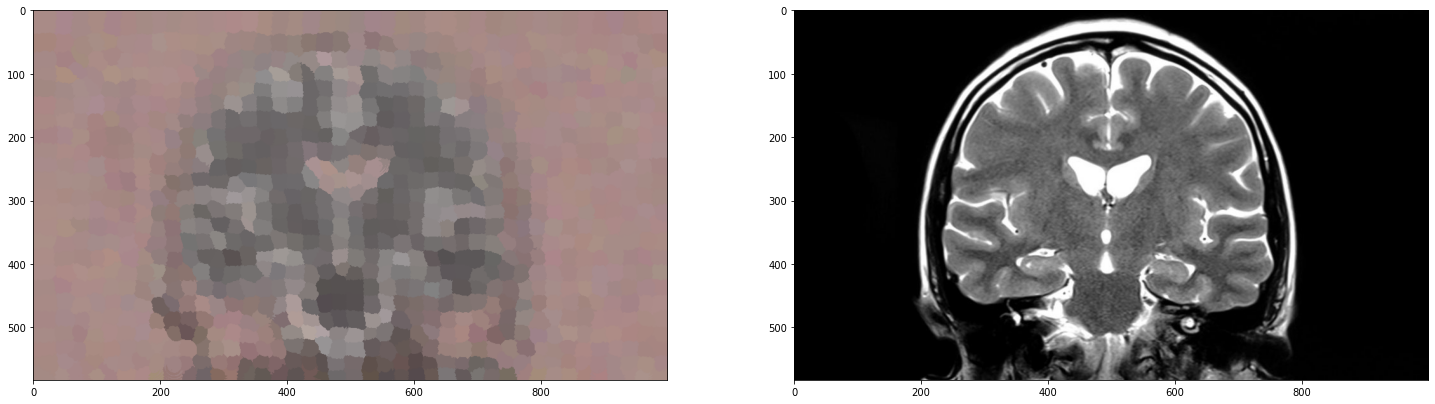

In [19]:
test = np.full(shape = lab_img.shape, fill_value = 0, dtype = np.uint8)

# possible_gray_levels = list(np.arange(0,1,1/k))
plt.figure(figsize = (10,15))
for cluster in clusters:
  mean_color = np.array([0,0,0])
  for x,y in cluster.pixels:
    mean_color += lab_img[x,y]

  mean_color = np.uint8(mean_color/len(cluster.pixels))
  for px,py in cluster.pixels:
    # print(color, px, py)
    test[px,py] = mean_color

test = cv2.cvtColor(test, cv2.COLOR_LAB2RGB)

plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.imshow(test)
plt.subplot(1,2,2)
plt.imshow(img)

100%|██████████| 582/582 [00:08<00:00, 69.01it/s]


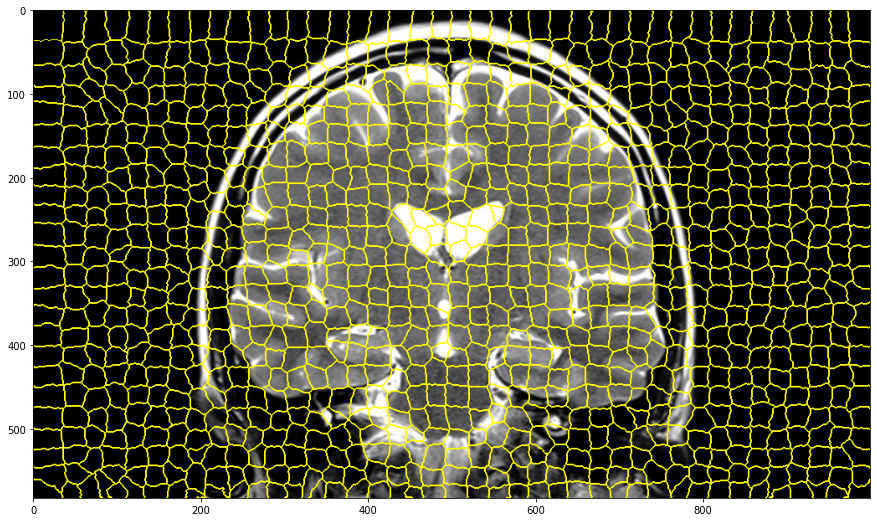

In [20]:
from skimage.segmentation import mark_boundaries
# plt.figure(figsize = (15,10))
# plt.imshow(mark_boundaries(img, new_L))

new_L_copy = new_L.copy()

# pra cada pixel
for i in tqdm(range(new_L_copy.shape[0]-1)):
  for j in range(new_L_copy.shape[1]-1):
    # olhar uma janela de certo tamanho ao redor dele
    window = new_L_copy[i-2:i+3, j-2:j+3]
    # se um pixel na janela for diferente do pixel central da janela
    # o elemento equivalente de diff_window = 1, senão é 0
    diff_window = 1*window != new_L_copy[i,j]
    # se a maioria for diferente
    if np.sum(diff_window)>12:
      # print("mudar pixel")
      # procura qual o label que possui a maior contagem
      # e dá esse label para aquele pixel
      pixels, count = np.unique(window, return_counts=True)
      index_count = np.where(count == np.max(count))[0][0]
      new_L_copy[i,j] = pixels[index_count]
    else:
      continue

plt.figure(figsize = (15,10))
plt.imshow(mark_boundaries(img, new_L_copy))

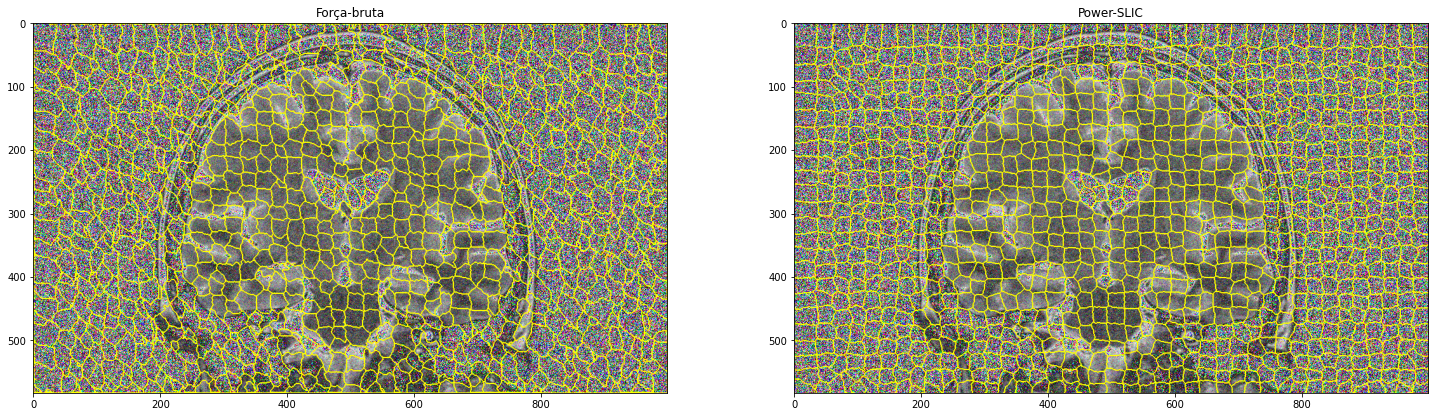

In [21]:
plt.figure(figsize = (25,10))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(gaussian_img, np.int8(L_copy*255), color = [1,1,0]))
plt.title("Força-bruta")

plt.subplot(1,2,2)
plt.imshow(mark_boundaries(gaussian_img, new_L_copy, color=[1,1,0]))
plt.title("Power-SLIC");

In [35]:
# achando os valores da borda de cada cluster
from collections import defaultdict
border_pixels = defaultdict(list)
for key in labels_dict.keys():
  i = key[0]
  j = key[1]

  value = labels_dict[(i,j)]
  for m in range(-1,2,1):
    for n in range(-1,2,1):
      if i+m > 0 and j+n > 0 and i+m < lab_img.shape[0] and j+n < lab_img.shape[1]:
        if labels_dict[(i+m, j+n)] != labels_dict[(i,j)] and (i,j) not in border_pixels:
          border_pixels[labels_dict[(i,j)]].append((i,j))
          break


In [55]:
# falta achar o quociente definido pelas equações 6 e 7 do artigo sobre Power SLIC
label_num = 180
border_pixels[label_num]

count_pixels_from_label = 0
for k,v in labels_dict.items():
  if v == label_num:
    count_pixels_from_label += 1

len(border_pixels[label_num])/count_pixels_from_label

0.2777222777222777

In [52]:
loop_count = 0
for item in labels_dict.items():
  if loop_count >= 200:
    print(item)
  loop_count +=1
  if loop_count ==250:
    break

((0, 200), 140)
((0, 201), 140)
((0, 202), 140)
((0, 203), 140)
((0, 204), 140)
((0, 205), 140)
((0, 206), 140)
((0, 207), 140)
((0, 208), 140)
((0, 209), 140)
((0, 210), 140)
((0, 211), 160)
((0, 212), 160)
((0, 213), 160)
((0, 214), 160)
((0, 215), 160)
((0, 216), 160)
((0, 217), 160)
((0, 218), 160)
((0, 219), 160)
((0, 220), 160)
((0, 221), 160)
((0, 222), 160)
((0, 223), 160)
((0, 224), 160)
((0, 225), 160)
((0, 226), 160)
((0, 227), 160)
((0, 228), 160)
((0, 229), 160)
((0, 230), 160)
((0, 231), 160)
((0, 232), 160)
((0, 233), 160)
((0, 234), 180)
((0, 235), 180)
((0, 236), 180)
((0, 237), 180)
((0, 238), 180)
((0, 239), 180)
((0, 240), 180)
((0, 241), 180)
((0, 242), 180)
((0, 243), 180)
((0, 244), 180)
((0, 245), 180)
((0, 246), 180)
((0, 247), 180)
((0, 248), 180)
((0, 249), 180)


## SLIC usando Skimage

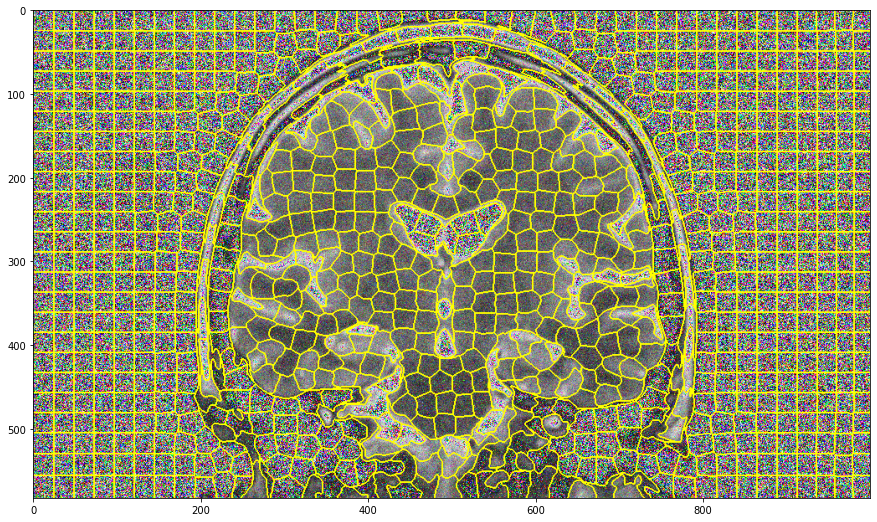

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

segments_slic = slic(image = img, n_segments=1000, compactness=20, sigma=1)

plt.figure(figsize = (15,10))
plt.imshow(mark_boundaries(gaussian_img, segments_slic))

In [ ]:
class Cluster():
  def __init__(self,center, index):
    self.center = center
    self.pixels = set()
    self.index = index
    self.cov_matrix = np.array([])
clusters = []

In [ ]:
#placeholder do D para testes
phD = np.full(D.shape, np.infty)
d = np.full(D.shape, 0)

xc = clusters[5].center[0]
yc = clusters[5].center[1]
h = 3

# janela na imagem LAB e no D max e min são usados para lidar com as bordas da imagem, i.e. não ir para valores menores que 0 e além da imagem
window = lab_img[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]
D_window = D[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]

# matriz cujos elementos são as posições daquela entrada
# pode ser inicializada uma única vez fora de loops para otimização
position_matrix = np.zeros((lab_img.shape[0],lab_img.shape[1], 2))
for i in range(position_matrix.shape[0]):
  for j in range(position_matrix.shape[1]):
    position_matrix[i,j] = [i,j]

# plt.imshow(window)
# np.int8(lab_img[0,1]) - np.int8(lab_img[250,150])

In [ ]:
from tqdm import tqdm
def compute_covmatrix(pixels):
  mean_x, mean_y = 0, 0

  # componentes da matriz de covariância
  C00, C01, C10, C11 = 0,0,0,0

  for px, py in pixels:
    mean_x += px
    mean_y += py

  mean_x = mean_x/len(pixels)
  mean_y = mean_y/len(pixels)


  for x,y in pixels:
    C00 += (x-mean_x)**2
    C01 += (x-mean_x)*(y-mean_y)
    C10 += (x-mean_x)*(y-mean_y)
    C11 += (y-mean_y)**2

  cov_matrix = np.array([[C00,C10],
                        [C01, C11]])/len(pixels)

  return cov_matrix

# for num in np.unique(segments_slic):
#   np.sum(img == num)
test = np.zeros(segments_slic.shape)
# x,y = np.where(segments_slic == 13)

for cluster_num in tqdm(np.unique(segments_slic)):
  x,y = np.where(segments_slic == cluster_num)
  cm = compute_covmatrix(list(zip(x,y)))
  center = (np.mean(x), np.mean(y))
  new_cluster = Cluster(center = center, index = cluster_num)

  new_cluster.pixels = set(list(zip(x,y)))
  new_cluster.cov_matrix = cm

  clusters.append(new_cluster)
# plt.imshow(test)

100%|██████████| 221/221 [00:09<00:00, 22.81it/s]


In [ ]:
def compute_modified_d(cov_matrix, pixel, center):
  px_vec = np.array([pixel[0], pixel[1]])
  center_vec = np.array([center[0], center[1]])

  subtraction = np.int8(px_vec) - np.int8(center_vec)

  return np.sqrt(np.matmul(subtraction,np.matmul(cov_matrix, subtraction.reshape(-1,1))))**2

img = np.array(img)
new_L = np.full((img.shape[0], img.shape[1]), -1)
D = np.full(shape = (img.shape[0], img.shape[1]), fill_value = np.infty)
h = 25

for cluster in tqdm(clusters):
  # acha o centro
  center = cluster.center
  cov_matrix = cluster.cov_matrix
  inv_cov_matrix = np.linalg.inv(cov_matrix)

  for i in range(int(center[0] - h), int(center[0] + h), 1):  
    if i >= 0 and i < np.array(img).shape[0]:
      for j in range(int(center[1] - h), int(center[1] + h), 1):
        if j >= 0 and j < np.array(img).shape[1]:
          d = compute_modified_d(inv_cov_matrix, pixel = (i,j), center = center)

          # se a distância for menor que a distância definida anteriormente
          # atualiza D, muda o label de L[i,j] e atualiza os pixels do cluster
          if d[0] < D[i,j]:
            D[i,j] = d
            new_L[i,j] = cluster.index
            cluster.pixels.add((i,j))
          
            # garante que caso um pixel seja adicionado a um cluster,
            # remove o pixel de outro cluster caso ele estivesse lá
            for c in clusters:
              if c.index != cluster.index and (i,j) in c.pixels:
                c.pixels.remove((i,j))

100%|██████████| 221/221 [03:36<00:00,  1.02it/s]


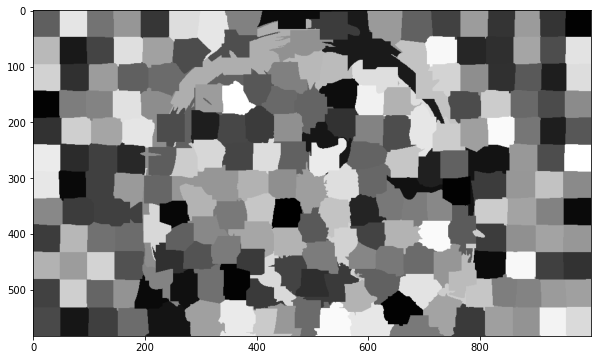

In [ ]:
import random
test = np.full(shape = (img.shape[0], img.shape[1]), fill_value = 0, dtype = np.float32)
k = 250
possible_gray_levels = list(np.arange(0,1,1/k))
plt.figure(figsize = (10,15))
for cluster in clusters:
  color = random.choice(possible_gray_levels)
  for px,py in cluster.pixels:
    # print(color, px, py)
    test[px,py] = color

plt.imshow(test, cmap = "gray")

In [ ]:
subtract = position_matrix[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)] - np.array([xc, yc])

ds = np.linalg.norm(subtract, axis = 2)**2

color_subtract = np.array(window, dtype = np.int8) -  np.array(lab_img[xc, yc], dtype = np.int8)

dc = np.linalg.norm(color_subtract, axis = 2)**2

d = np.sqrt(((m/h)**2)*dc + ds)
d

phD = np.full((7,7), 3)
# d_condition = d < phD[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]
d_condition = d<phD

# phD[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)] 
# d[int(d.shape[0]/2), int(d.shape[0]/2)] = np.infty

# máscara para comparar d e D
final = ~d_condition*1*phD + d_condition*1*d
final[int(d.shape[0]/2), int(d.shape[0]/2)] = np.infty
final

d_condition*d

L[max(0,xc-h):min(lab_img.shape[1] - 1,xc+h+1), max(0,yc-h):min(lab_img.shape[1] - 1, yc+h+1)]
x_range = list(range(max(0,xc-h),min(lab_img.shape[1] - 1,xc+h+1)))
y_range = list(range(max(0,yc-h),min(lab_img.shape[1] - 1, yc+h+1)))
x_range, y_range

#determinar a relação entre os índices do L e do d_condition para poder colocar os pixels (encontrados através de L) em cluster.pixels
d_xs = list(range(0,d_condition.shape[0]))
d_ys = list(range(0, d_condition.shape[1]))

zip_iter_x = zip(d_xs, x_range)
zip_iter_y = zip(d_ys, y_range)
x_conversion_dict = dict(zip_iter_x)
y_conversion_dict = dict(zip_iter_y)

# com isso, dá pra saber quais pixels satisfazem a condição d < D para armazenar em cluster.pixels
print(x_conversion_dict, y_conversion_dict)

x_cond, y_cond = np.where(d_condition == 1)

pixels_with_label = list(zip(x_cond, y_cond))
print(pixels_with_label)
d_condition == 1

labels_dict = dict()
for i in range(lab_img.shape[0]):
  for j in range(lab_img.shape[1]):
    labels_dict[(i,j)] = -1

for px, py in pixels_with_label:
  px_true = x_conversion_dict[px]
  py_true = y_conversion_dict[py]
  labels_dict[(px_true, py_true)] = 2

pixels_of_cluster = [k for k,v in labels_dict.items() if v == 2]
set(pixels_of_cluster)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 2.82842712, 2.23606798, 2.        , 2.23606798,
        2.82842712, 0.        ],
       [0.        , 2.23606798, 1.41421356, 1.        , 1.41421356,
        2.23606798, 0.        ],
       [0.        , 2.        , 1.        , 0.        , 1.        ,
        2.        , 0.        ],
       [0.        , 2.23606798, 1.41421356, 1.        , 1.41421356,
        2.23606798, 0.        ],
       [0.        , 2.82842712, 2.23606798, 2.        , 2.23606798,
        2.82842712, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])